# MUSTANG Data Quality Metrics Exercise
*:auth: Nate Stevens (Pacific Northwest Seismic Network)*

In this notebook we'll query data quality metrics from the MUSTANG measurements webservice  
provided by EarthScope/SAGE to get a sense of data availability and usefullness BEFORE  
downloading a ton of data!  

What is MUSTANG? - A continually growing data quality statistics dataset  
for every seismic station stored on the Data Management Center!  

What does MUSTANG stand for? - The **M**odular **U**tility for **STA**tistical k**N**owldege **G**athering system  

Where can I go to learn more about MUSTANG? 
https://service.iris.edu/mustang/  

Dependencies:   
 - `ObsPy`  
 - `Pyrocko`  
 - `mustang_client` (`mustang_client.py`)  


In [1]:
## IMPORT MODULES
from obspy import UTCDateTime, Trace
from obspy.clients.fdsn import Client
# Tools for data visualization
import matplotlib.pyplot as plt
from pyrocko import obspy_compat
# Custom Client for getting MUSTANG station quality metrics from IRIS web services
from mustang_client import MustangClient

In [2]:
# Initialize Clients
mclient = MustangClient()
wclient = Client('IRIS')

# IYKYK, or you will soon enough!
obspy_compat.plant()

## Composing a MUSTANG query  
The `MustangClient` class' `get_metrics` follows the `key=value` syntax of the MUSTANG measurements service interface  
(https://service.iris.edu/mustang/measurements/1/)  
where multiple values can be provided as a comma-delimited string.

This version of the `MustangClient` can also parse lists of metric names (see below).  

The full list of MUSTANG metrics and detailed descriptions of their meaning can be found at the link above.  

The metrics we'll use in this exercise are:  

 - *`sample_min`*: the minimum sample value observed in a 24 hour period  

 - *`max_range`*: the maximum range between any two samples in a 5 minute window within a 24 hour period  

 - *`percent_availability`*: the percent of a 24 hour period for which there are data  

 - *`sample_unique`*: number of unique sample values reported in a 24 hour window  

 - *`num_gaps`*: number of data gaps encountered within a 24 hour window


The seismic station we're looking at is UW.MBW.01.EHZ, one of the longest running stations in the PNSN that  
monitored Mount Baker volcano until late 2023 when it was replaced with UW.MBW2.  

UW.MBW was having some issues towards the end, so lets pull a year of MUSTANG metrics for UW.MBW.01.EHZ and identify a few.

In [7]:
# Compose a query for a year's worth of MUSTANG metrics from IRIS Webservices
# for an analog seismometer near Mount Baker (Washington, USA)
metric = ['sample_min','max_range','percent_availability','sample_unique','num_gaps']
query = {'metric': metric,
            'net':'UW',
            'sta':'MBW',
            'loc':'01',
            'cha':'EHZ',
            'start':'2023-01-01T00:00:00',
            'end':  '2023-12-31T00:00:00'}
# Run query
df = mclient.get_metrics(**query, indexing='start')

,target,max_range,sample_unique,sample_min,num_gaps,percent_availability
start,,,,,,
2023-01-01,UW.MBW.01.EHZ.M,3346.0,10.0,0.0,3.0,99.994
2023-01-02,UW.MBW.01.EHZ.M,36284.0,217.0,-7981.0,7.0,99.825
2023-01-03,UW.MBW.01.EHZ.M,5.0,13.0,3347.0,8.0,99.981
2023-01-04,UW.MBW.01.EHZ.M,3355.0,11.0,0.0,8.0,99.480
2023-01-05,UW.MBW.01.EHZ.M,3352.0,23.0,0.0,13.0,99.846
...,...,...,...,...,...,...
2023-12-26,UW.MBW.01.EHZ.M,6.0,15.0,3337.0,5.0,99.994
2023-12-27,UW.MBW.01.EHZ.M,56152.0,838.0,-27822.0,6.0,99.993
2023-12-28,UW.MBW.01.EHZ.M,3341.0,10.0,0.0,12.0,99.987


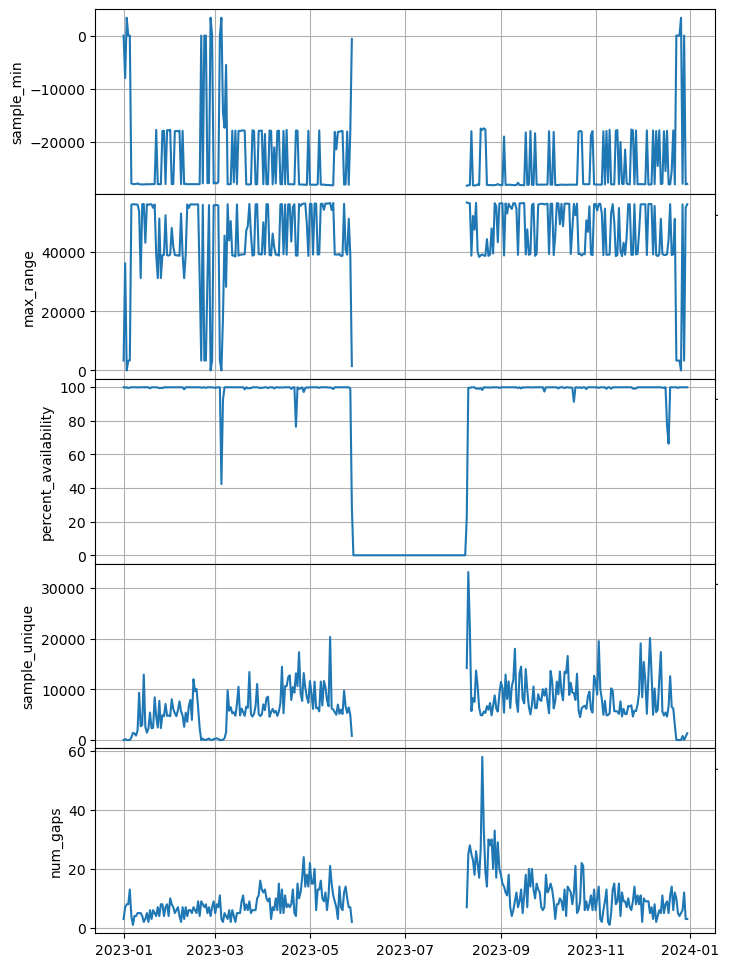

In [8]:
# What do we see?
display(df)
fig = plt.figure(figsize=(8,12))
gs = fig.add_gridspec(nrows=len(query['metric']), hspace=0)
for _e, _m in enumerate(query['metric']):
    ax = fig.add_subplot(gs[_e])
    ax.plot(df[_m])
    ax.set_ylabel(_m)
    ax.grid()


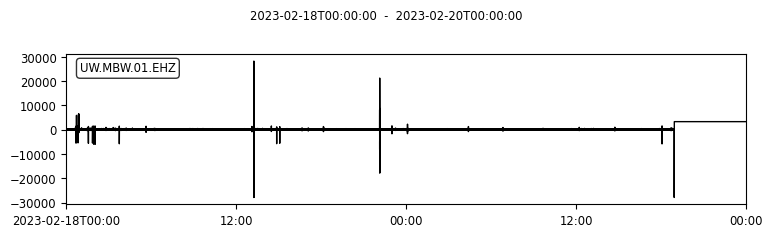

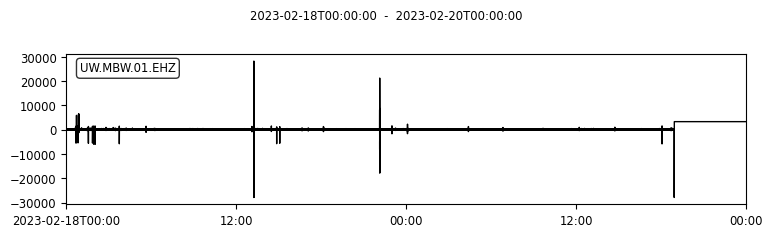

In [10]:
# Late February 2023 seems a bit gnarly - let's do visual QC on waveforms
st = wclient.get_waveforms(
    network='UW',station='MBW',location='01',channel='EHZ',
    starttime=UTCDateTime('20230218'), endtime=UTCDateTime('20230220'))
st.plot(method='full')

In [14]:
# Let's take a closer, interactive look
st2 = st.copy()
# # Build time series as traces 
# for _m in query['metric']:
#     tr = Trace(data=df[_m].values, 
#                header={'network':'UW',
#                        'station':'MBW',
#                        'location':'01',
#                        'channel':_m,
#                        'sampling_rate': 1/(24*3600),
#                        'starttime':UTCDateTime(df[_m].index[0].timestamp())})
#     st2+= tr
(exit_code, pile) = st2.snuffle()